# Lab 0: Intro to ADQL and Gaia Data

In [2]:
import time
import os
import io
import requests
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from IPython.display import display, HTML
from astroquery.gaia import Gaia
from astropy.table import Table
from joblib import Memory

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['figure.figsize'] = 8, 5
sns.set_style("whitegrid")

In [4]:
cachedir = './joblib_cache'
# 1e7 nytes (10 MB)
# verbose=0: no verbose output during caching
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

@memory.cache
def get_gaia_query(q):
    start = time.time()
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time()-start:0.2f} sec")
    return job.get_results()

# Define function to process data and plot
def process_and_plot_cmd(color, absmag, title):
    """Function to process and plot color
    and absolute magnitude data.
    """
    
    nan_mask = np.isnan(absmag) | np.isnan(color)
    color_no_nan = color[~nan_mask]
    abs_mag_no_nan = absmag[~nan_mask]

    plt.scatter(color_no_nan, abs_mag_no_nan, marker=".", c="black", s=10)
#     plt.xlim(-1, 5)
#     plt.ylim(-2, 18.75)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.xlabel("BP - RP [mag]")
    plt.ylabel(r"M$_{G}$ [mag]")
    plt.title(title)
    
def process_and_plot_pm(pmra, pmdec, title):
    """Function to process and plot color
    and absolute magnitude data.
    """
    
    nan_mask = np.isnan(pmra) | np.isnan(pmdec)
    pmra_no_nan = pmra[~nan_mask]
    pmdec_no_nan = pmdec[~nan_mask]

    plt.scatter(pmra_no_nan, pmdec_no_nan, marker=".", c="black", s=10)
    plt.grid()
    plt.xlabel(r"$\mu_{\alpha^*}$ [mas/yr]")
    plt.ylabel(r"$\mu_{\delta^*}$ [mas/yr]")
    plt.title(title)

# 0.1 Hyades

The information for the Hyades cluster are from F. van Leeuwen 2009.

Center: right ascension $\alpha_0 = 4^{\text{h}}26^{\text{m}}$ or $66.5^{\circ}$, declination $\delta_0 = 16^{\circ}54'$ or $16.9^{\circ}$ $\to \left(\alpha_0, \delta_0\right) = \left(66.5^{\circ},16.9^{\circ}\right)$. A cone search of radius 18.54$^{\circ}$/1112.4 arcmin was applied around the cluster's center. The mean parallax was determined in the paper to be $\varpi \approx 21.53 \pm 2.76$ mas.

The gaia query for the astrometry/photometry quality filter was recommended in Babusiaux et al 2018.

## 0.1.1 Color Magnitude Diagrams (CMD) and Proper Motion (PM) Plots

### 0.1.1.2 Without Proper Motion Cuts

In [5]:
# Hyades query without filters
# no proper motion cuts
hyades_q_nf = """SELECT DISTANCE(66.5, 16.9, ra, dec) AS ang_sep,
            phot_g_mean_mag+5*log10(parallax)-10 AS mg,
            bp_rp,ra,dec,source_id,parallax,pm,pmra,pmdec
        FROM gaiadr3.gaia_source
        WHERE DISTANCE(66.5, 16.9, ra, dec) < 1112.4/60.
            AND parallax < 21.53 + 2.76
            AND parallax > 21.53 - 2.76
"""

# Filtering out unreliable astrometry and photometry
# filters from Babusiaux et al. 2018, Section 2.1
hyades_q_f = """SELECT DISTANCE(66.5, 16.9, ra, dec) AS ang_sep,
            phot_g_mean_mag+5*log10(parallax)-10 AS mg,
            bp_rp,ra,dec,source_id,parallax,pm,pmra,pmdec
        FROM gaiadr3.gaia_source
        WHERE DISTANCE(66.5, 16.9, ra, dec) < 1112.4/60.
            AND parallax_over_error > 10
            AND parallax < 21.53 + 2.76
            AND parallax > 21.53 - 2.76
            AND phot_g_mean_flux_over_error>50
            AND phot_rp_mean_flux_over_error>20
            AND phot_bp_mean_flux_over_error>20
            AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND visibility_periods_used>8
            AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
"""

In [6]:
hyades_tbl_nf = get_gaia_query(hyades_q_nf)
hyades_tbl_f = get_gaia_query(hyades_q_f)

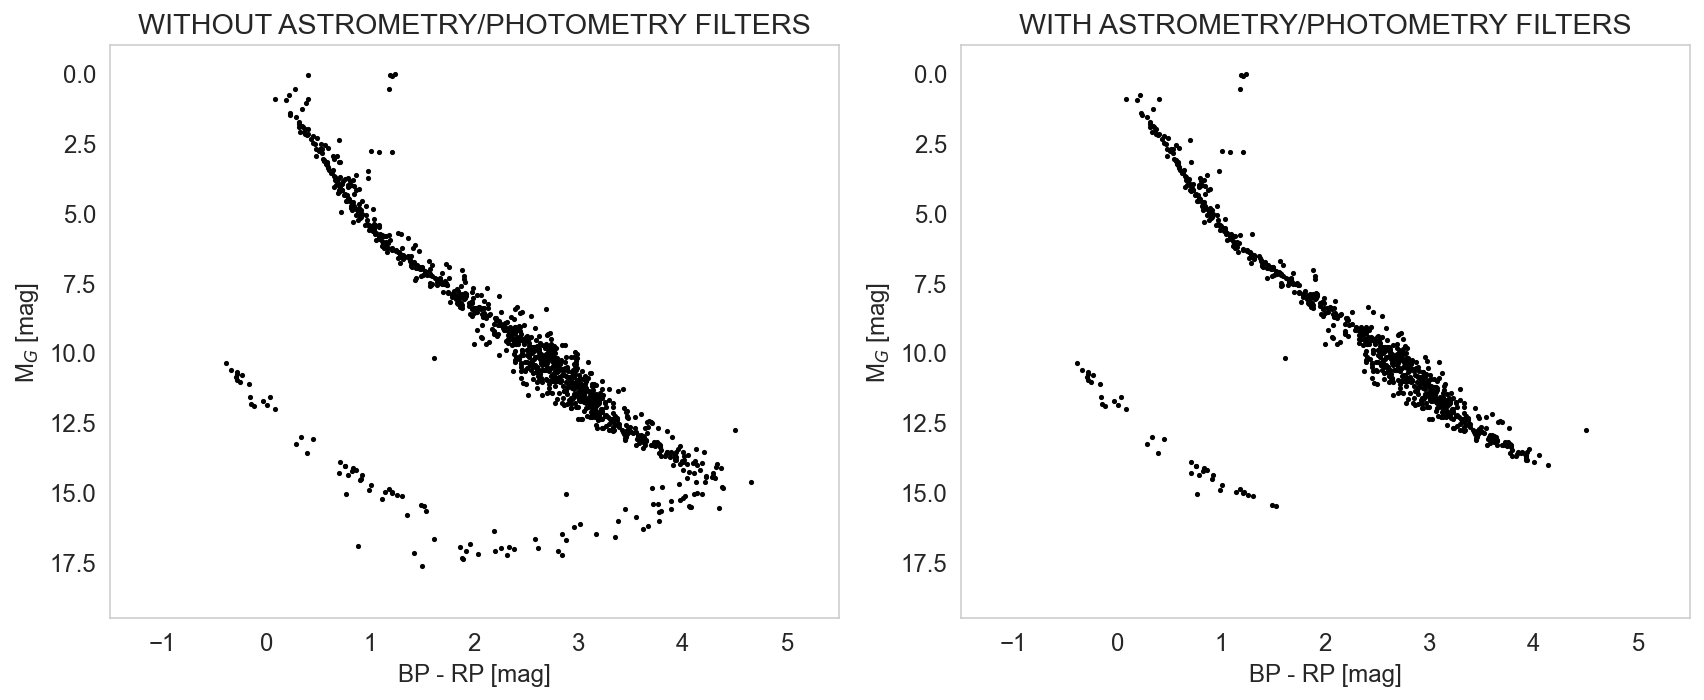

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
process_and_plot_cmd(hyades_tbl_nf["bp_rp"], hyades_tbl_nf["mg"], "WITHOUT ASTROMETRY/PHOTOMETRY FILTERS")
plt.xlim(-1.5, 5.5)
plt.ylim(19.5, -1.0)

plt.subplot(1, 2, 2)
process_and_plot_cmd(hyades_tbl_f["bp_rp"], hyades_tbl_f["mg"], "WITH ASTROMETRY/PHOTOMETRY FILTERS")
plt.xlim(-1.5, 5.5)
plt.ylim(19.5, -1.0)

plt.tight_layout()
plt.show()

In [89]:
print(len(hyades_tbl_nf))
print(len(hyades_tbl_f))

1144
853


The gaia query returns many more sources than there are members believed to be part of the Hyades cluster. Table 2 from Babusiaux lists 480 members for the Hyades cluster, and other literatures place the number of members within the same range. Observe that the astrometry/photometry filters removed artefacts between the faint end of the MS branch and the WD branch. The quality filters also reduced the number of faint sources.

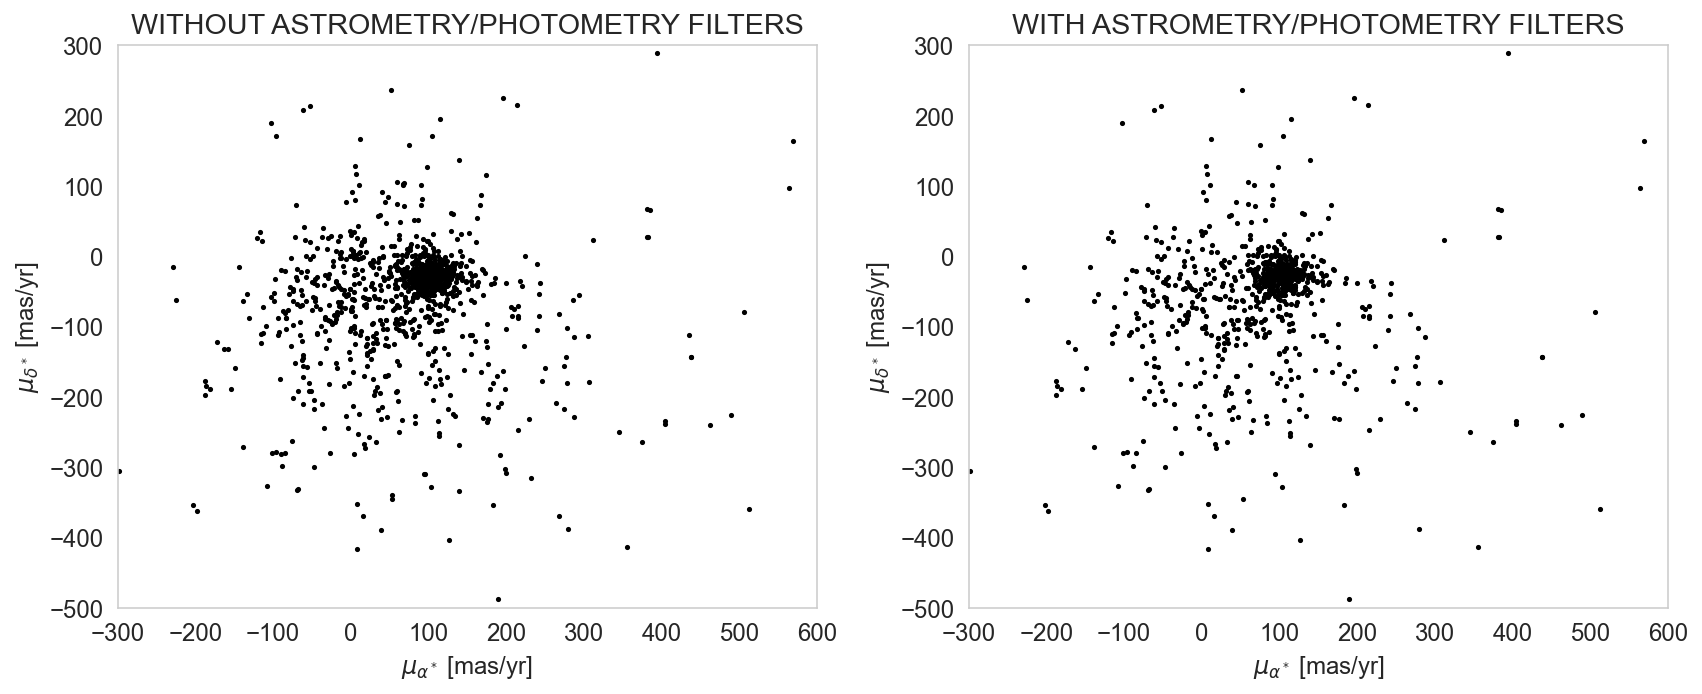

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
process_and_plot_pm(hyades_tbl_nf["pmra"], hyades_tbl_nf["pmdec"], "WITHOUT ASTROMETRY/PHOTOMETRY FILTERS")
plt.xlim(-300, 600)
plt.ylim(-500, 300)

plt.subplot(1, 2, 2)
process_and_plot_pm(hyades_tbl_f["pmra"], hyades_tbl_f["pmdec"], "WITH ASTROMETRY/PHOTOMETRY FILTERS")
plt.xlim(-300, 600)
plt.ylim(-500, 300)

plt.tight_layout()
plt.show()

The proper motion space plots show a clear clump of stars in the ranges $50 \, \text{mas/yr} < \mu_{\alpha^*} < 180 \, \text{mas/yr}$ and $-100 \, \text{mas/yr} < \mu_{\delta^*} < 20 \, \text{mas/yr}$. This is in agreement with the proper motion values (in right ascension and declination) shown in Table A.3. of Babusiaux 2018 for the Hyades cluster: $\mu_{\alpha^*}\approx101.005\pm0.171 \, \text{mas/yr}$ and $\mu_{\delta^*}\approx-28.490\pm0.137 \, \text{mas/yr}$.

### 0.1.1.2 With Proper Motion Cuts

In [9]:
hyades_pmcut = lambda tbl: (
    (tbl["pmra"] < 180) &
    (tbl["pmra"] > 50) &
    (tbl["pmdec"] > -100) &
    (tbl["pmdec"] < 20)
)

hyades_tbl_pmcut_nf = hyades_tbl_nf[hyades_pmcut(hyades_tbl_nf)]
hyades_tbl_pmcut_f = hyades_tbl_f[hyades_pmcut(hyades_tbl_f)]

In [92]:
print(len(hyades_tbl_pmcut_nf))
print(len(hyades_tbl_pmcut_f))

620
455


With the rough proper motion cuts and quality filters apply, the number of sources become more reasonable with accepted amount of cluster members.

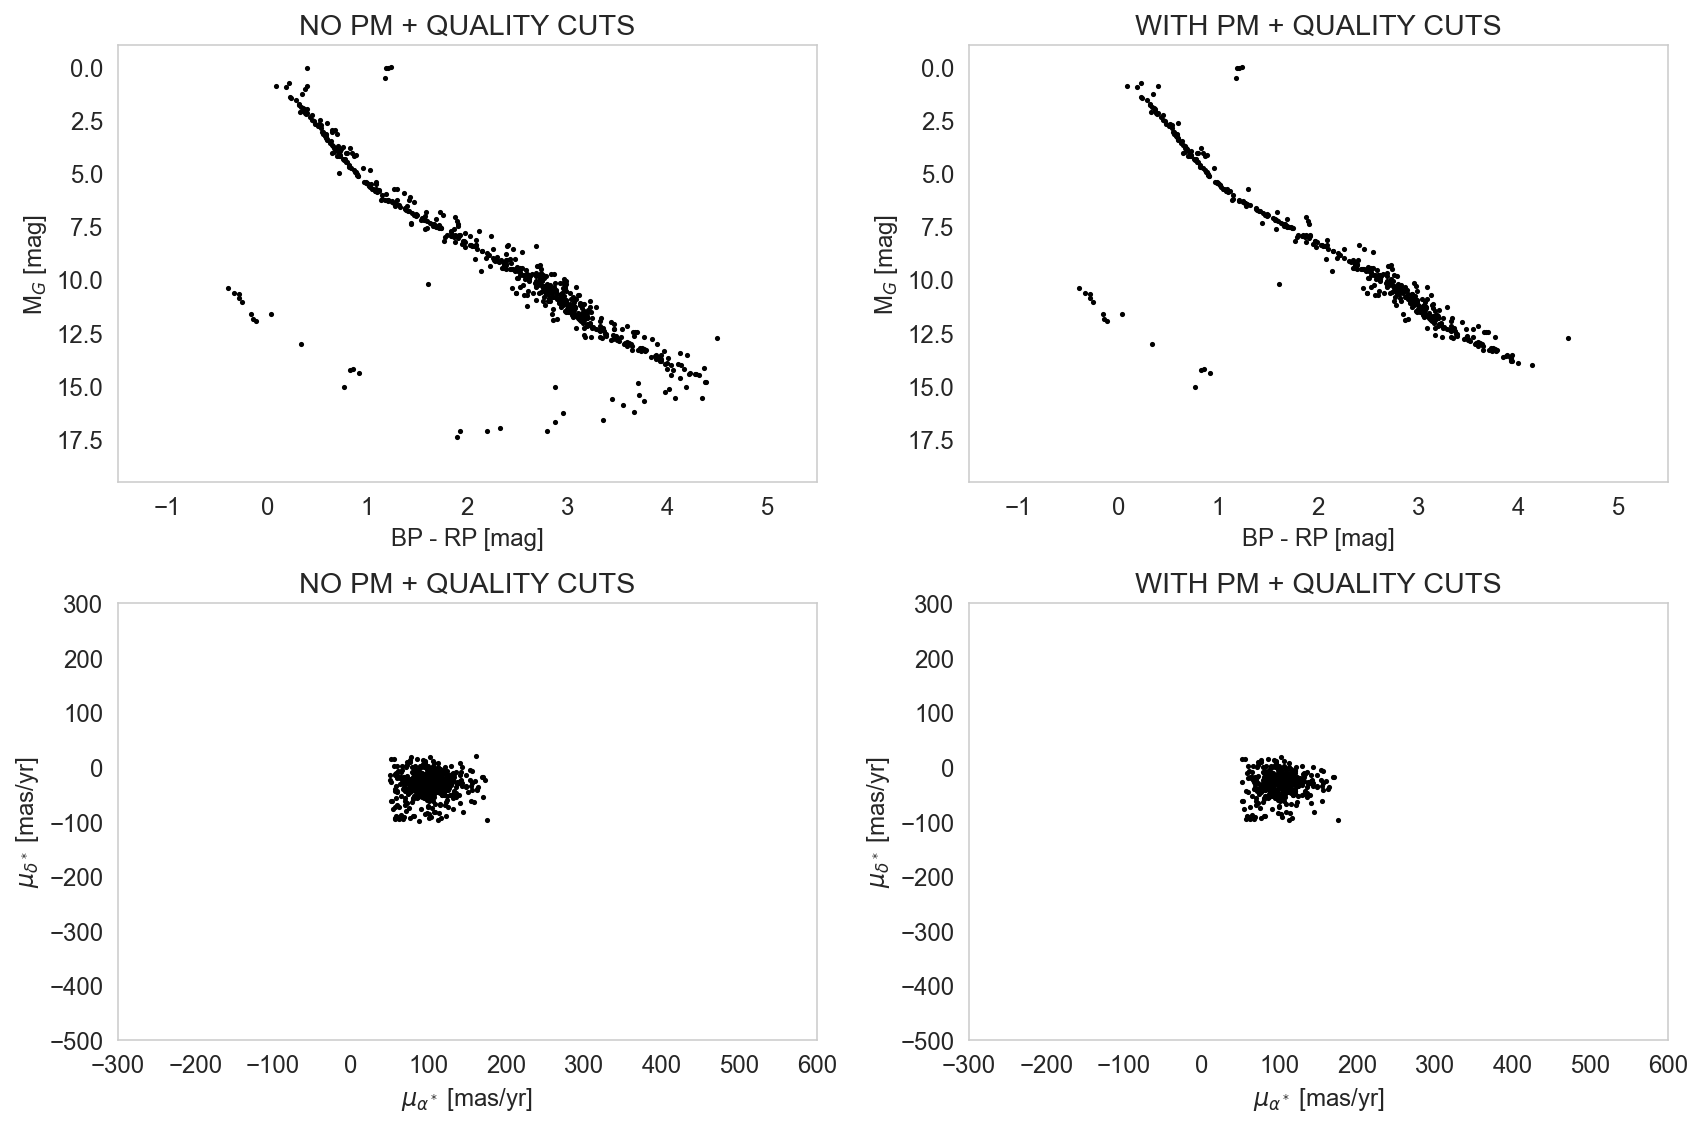

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
process_and_plot_cmd(hyades_tbl_pmcut_nf["bp_rp"], hyades_tbl_pmcut_nf["mg"], "NO PM + QUALITY CUTS")
plt.xlim(-1.5, 5.5)
plt.ylim(19.5, -1.0)

plt.subplot(2, 2, 2)
process_and_plot_cmd(hyades_tbl_pmcut_f["bp_rp"], hyades_tbl_pmcut_f["mg"], "WITH PM + QUALITY CUTS")
plt.xlim(-1.5, 5.5)
plt.ylim(19.5, -1.0)

plt.subplot(2, 2, 3)
process_and_plot_pm(hyades_tbl_pmcut_nf["pmra"], hyades_tbl_pmcut_nf["pmdec"], "NO PM + QUALITY CUTS")
plt.xlim(-300, 600)
plt.ylim(-500, 300)

plt.subplot(2, 2, 4)
process_and_plot_pm(hyades_tbl_pmcut_f["pmra"], hyades_tbl_pmcut_f["pmdec"], "WITH PM + QUALITY CUTS")
plt.xlim(-300, 600)
plt.ylim(-500, 300)

plt.tight_layout()
plt.show()

The addition of proper motion cuts also cleaned up the CMDs, but not as significantly as the quality cuts. The majority of sources in the CMD occupy the Main Sequence (MS), or the main prominent line in the CMD. There are only a handful of sources in the Red Giant Branch (RGB) near the top of the MS and some sources in the White Dwarf (WD) region in the lower left half of the CMD. All of these observations from the data line up with what is known in the literature about the Hyades. It is a young cluster, of around 800 Myr (Babusiaux 2018), so it is reasonable that the majority of gaia sources occupy the MS.

## 0.1.2 Model Tracks

Babusiaux's values for the age and metallicity of the Hyades cluster can be used to compare the gaia data to theoretical isochrone models. The age was determined in Babusiaux to be $\log\left(\text{age}\right) = 8.90$ or roughly 800 Myr and the metallicity is $Z = 0.020$. In the plots below, a range around these values were used to obtain models with fixed age and metallicity. Two models were used: MIST and PARSEC. The same range for age and metallicity was used for both models for comparison.

### 0.1.2.1 MIST

In [12]:
### MIST FIXED AGE DATA PROCESSING ###

mist_path = "MIST_v1.2_vvcrit0.0_UBVRIplus/"

def process_data_file(directory, age):
    # List .iso.cmd files in directory
    files = [f for f in os.listdir(directory) if f.endswith(".iso.cmd")]
    
    processed_data_list=[]
    
    for filename in files:
        filepath = os.path.join(directory, filename)
        # read each file
        table = Table.read(filepath, format='ascii', header_start=-1)
        processed_data = process_data(table, age)
        processed_data_list.append(processed_data)
    
    return processed_data_list        
            
def process_data(table, age):
    processed_data = table[
        (table["log10_isochrone_age_yr"]==age)&
        (table["phase"]>=-1.0)&
        (table["phase"]<3.0)
    ]
    return processed_data

In [13]:
### MIST FIXED METALLICITY ###
tmist_hyades_fixed_z = Table.read("hyades_MIST/MIST_iso_65b700c4e3770.iso.cmd", format="ascii", header_start=-1)

### MIST FIXED AGE ###
tmist_hyades_fixed_age_list = process_data_file(mist_path, 8.9)
tmist_hyades_fixed_age_list_sorted = sorted(tmist_hyades_fixed_age_list, key=lambda x: x["[Fe/H]_init"][0])
tmist_hyades_fixed_age_list_sorted = tmist_hyades_fixed_age_list_sorted[-5:]

### 0.1.2.2 PARSEC

In [14]:
### PARSEC FIXED METALLICITY ###

parsec_path = "hyades_PARSEC/"

tparsec_hyades_fixed_z = Table.read(parsec_path + "output330094674908.dat", format='ascii', header_start=-2)

### PARSEC FIXED AGE ###

tparsec_hyades_fixed_age = Table.read(parsec_path + "output267099092322.dat", format='ascii', header_start=-2)

### 0.1.2.3 MIST AND PARSEC ISOCHRONE PLOTS

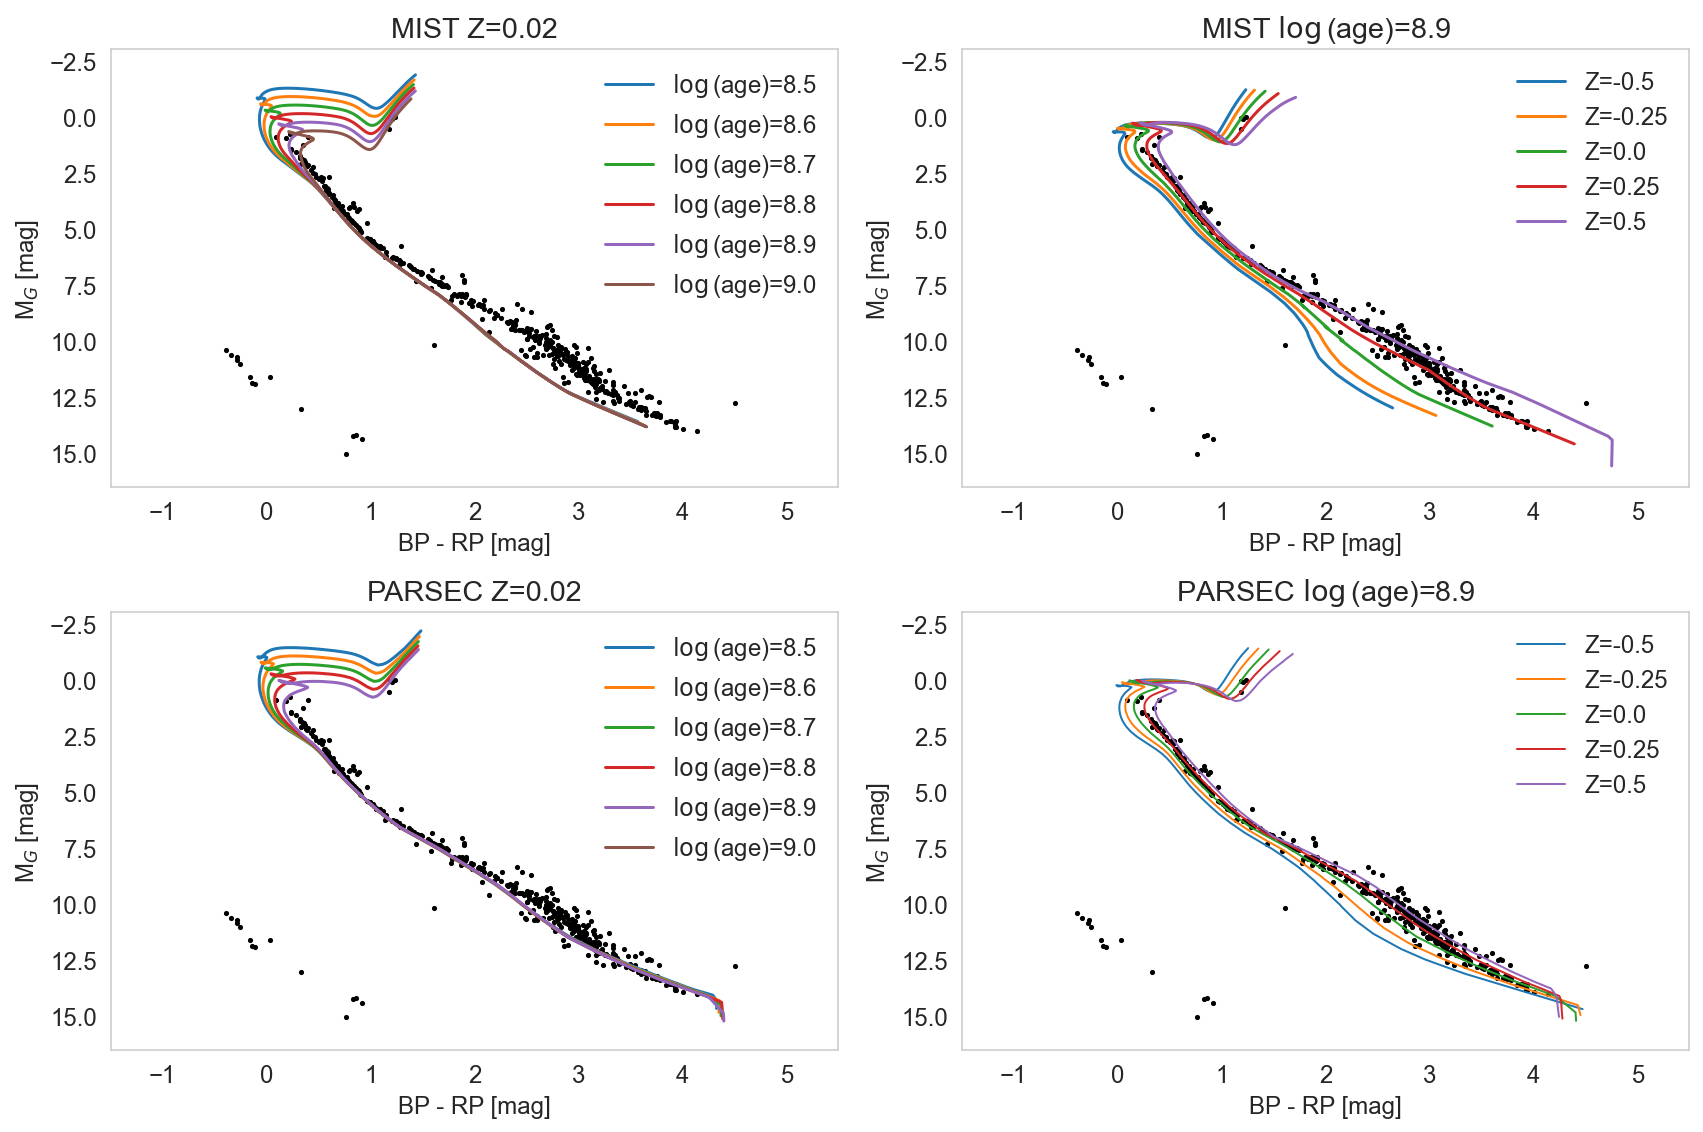

In [15]:
### MIST FIXED METALLICITY ###

hyades_log_age = np.array([8.5, 8.6, 8.7, 8.8, 8.9, 9.0])

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
process_and_plot_cmd(hyades_tbl_pmcut_f["bp_rp"], hyades_tbl_pmcut_f["mg"], "MIST Z=0.02")

for i, age in enumerate(hyades_log_age):
    # filter for MS, RGB, and age
    tmist_hyades_fixed_z_filtered = tmist_hyades_fixed_z[
        (tmist_hyades_fixed_z["log10_isochrone_age_yr"]==age)&
        (tmist_hyades_fixed_z["phase"]>=-1.0)&
        (tmist_hyades_fixed_z["phase"]<3.0)
    ]
    mist_hyades_fixed_z_BP_RP = tmist_hyades_fixed_z_filtered["Gaia_BP_EDR3"] - tmist_hyades_fixed_z_filtered["Gaia_RP_EDR3"]
    mist_hyades_fixed_z_G = tmist_hyades_fixed_z_filtered["Gaia_G_EDR3"]
    plt.plot(mist_hyades_fixed_z_BP_RP, mist_hyades_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))

plt.xlim(-1.5, 5.5)
plt.ylim(16.5, -3.0)
plt.legend(frameon=False)

### MIST FIXED AGE ###

plt.subplot(2,2,2)
process_and_plot_cmd(hyades_tbl_pmcut_f["bp_rp"], hyades_tbl_pmcut_f["mg"], r"MIST $\log$(age)=8.9")

for i, processed_data in enumerate(tmist_hyades_fixed_age_list_sorted):
    mist_hyades_zini = processed_data["[Fe/H]_init"][0]
    mist_hyades_fixed_age_BP_RP = processed_data["Gaia_BP_EDR3"] - processed_data["Gaia_RP_EDR3"]
    mist_hyades_fixed_age_G = processed_data["Gaia_G_EDR3"]
    plt.plot(mist_hyades_fixed_age_BP_RP, mist_hyades_fixed_age_G, 
             label=f"Z={mist_hyades_zini}", c=plt.cm.tab10(i))

plt.xlim(-1.5, 5.5)
plt.ylim(16.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED METALLICITY ###

plt.subplot(2,2,3)
process_and_plot_cmd(hyades_tbl_pmcut_f["bp_rp"], hyades_tbl_pmcut_f["mg"], "PARSEC Z=0.02")


for i, age in enumerate(hyades_log_age):
    tparsec_hyades_fixed_z_filtered = tparsec_hyades_fixed_z[
        (tparsec_hyades_fixed_z["logAge"]==age)&
        (tparsec_hyades_fixed_z["label"]>=0)&
        (tparsec_hyades_fixed_z["label"]<4)
    ]
    
    parsec_hyades_fixed_z_BP_RP = tparsec_hyades_fixed_z_filtered["G_BPmag"] - tparsec_hyades_fixed_z_filtered["G_RPmag"]
    parsec_hyades_fixed_z_G = tparsec_hyades_fixed_z_filtered["Gmag"]
#     mask = (PARSEC_BP_RP <= 5.0)&(PARSEC_G >= -2.5)&(PARSEC_G <= 14.0)
#     PARSEC_G_filtered = PARSEC_G[mask]
#     PARSEC_BP_RP_filtered = PARSEC_BP_RP[mask]
    plt.plot(parsec_hyades_fixed_z_BP_RP, parsec_hyades_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))
    
plt.xlim(-1.5, 5.5)
plt.ylim(16.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED AGE ###

hyades_zinit = np.array([-0.5, -0.25, 0.0, 0.25, 0.5])

plt.subplot(2,2,4)
process_and_plot_cmd(hyades_tbl_pmcut_f["bp_rp"], hyades_tbl_pmcut_f["mg"], r"PARSEC $\log$(age)=8.9")

for i, z in enumerate(hyades_zinit):
    tparsec_hyades_fixed_age_filtered = tparsec_hyades_fixed_age[
        (tparsec_hyades_fixed_age["MH"]==z)&
        (tparsec_hyades_fixed_age["label"]>=0)&
        (tparsec_hyades_fixed_age["label"]<4)
    ]
    parsec_hyades_fixed_age_BP_RP = tparsec_hyades_fixed_age_filtered["G_BPmag"] - tparsec_hyades_fixed_age_filtered["G_RPmag"]
    parsec_hyades_fixed_age_G = tparsec_hyades_fixed_age_filtered["Gmag"]
    plt.plot(parsec_hyades_fixed_age_BP_RP, parsec_hyades_fixed_age_G, 
             label=f"Z={z}", c=plt.cm.tab10(i), linewidth=1.0)
    
plt.xlim(-1.5, 5.5)
plt.ylim(16.5, -3.0)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

At a first glance it can be seen that the PARSEC model approximates the the gaia data along the MS with more accuracy than the MIST model. When metallicity is fixed, it can be seen that the older isochrone models fit to the location of the RGB from the gaia data more accurately than the younger isochrone models. The MIST model would place the age range for Hyades to be around 600 Myr to 1 Gyr, while the PARSEC model age range is more narrow at 800 Myr to 1 Gyr. With how both models fitting well with the gaia data for values greater than 8.8, it can at best be estimated that the Hyades is no younger than 600 Myr.

MIST and PARSEC place the range of metallicity between 0.25 and 0.5, widely different from the value obtained from Babusiaux. This is possibly due to the limitation in the range of metallicity from the set of isochrone models obtained from the MIST site (the same range was then used to obtain PARSEC model, for comparison sake). It is also possible that the G band magnitude from MIST was not properly converted to the G band magnitude obtained in the query, causing the isochrones to shift vertically downwards. If the magnitude value in the G band were increased slightly, then both models would more accurately approximate the metallicity to between 0.0 and 0.25.

The theoretical models assume single star systems. Assuming that they approximate the data well, then binary (or higher order) systems can be identified by stars that appear to be brighter/dimmer than the brightness values outlined by the isochrones. In essence, sources that are spread out along the isochrone models can be multi-star systems.

# 0.2 Messier 67 (NGC 2682)

Information used for M67 gaia query were found in Table A.4. from Babusiaux 2018: $\alpha = 132.8476^{\circ}$, $\delta = 11.8369^{\circ}$, $\varpi = 1.1325 \pm 0.0011$ mas, $\mu_{\alpha} = -10.9737 \pm 0.0064$ mas/yr, $\mu_{\delta} = -2.9396 \pm 0.0063$ mas/yr. Unlike Hyades, both proper motion and quality cuts are applied in the query. Parallax and proper motion were ranged to about $\pm 1$ of literature values to obtain reasonable number of sources. The cone search radius was also iterated for the same reason.

In [20]:
# M67 with astrometry and photometry filters
m67_q_f = """SELECT DISTANCE(132.8476, 11.8369, ra, dec) AS ang_sep,
            phot_g_mean_mag+5*log10(parallax)-10 AS mg,
            bp_rp,ra,dec,source_id,parallax,pm,pmra,pmdec
        FROM gaiadr3.gaia_source
        WHERE DISTANCE(132.8476, 11.8369, ra, dec) < 45./60.
            AND parallax_over_error > 10
            AND parallax < 1.1325 + 1.0
            AND parallax > 1.1325 - 1.0
            AND pmra < -10.9737 + 1.0
            AND pmra > -10.9737 - 1.0
            AND pmdec < -2.9396 + 1.0
            AND pmdec > -2.9396 - 1.0
            AND phot_g_mean_flux_over_error>50
            AND phot_rp_mean_flux_over_error>20
            AND phot_bp_mean_flux_over_error>20
            AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND visibility_periods_used>8
            AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
"""

In [17]:
m67_tbl_f = get_gaia_query(m67_q_f)

print(len(m67_tbl_f))

1047


The number of sources from this gaia query reasonable when compared to the 1194 cluster members from Babusiaux. The same process for comparison with isochrone models will be performed below.

In [21]:
### MIST FIXED METALLICITY ###

tmist_m67_fixed_z = Table.read("m67_MIST/MIST_iso_65bb2afecd6a8.iso.cmd", format="ascii", header_start=-1)

### MIST FIXED AGE ###

tmist_m67_fixed_age_list = process_data_file(mist_path, 9.5)
tmist_m67_fixed_age_list_sorted = sorted(tmist_m67_fixed_age_list, key=lambda x: x["[Fe/H]_init"][0])
tmist_m67_fixed_age_list_sorted = tmist_m67_fixed_age_list_sorted[-5:]

### PARSEC FIXED METALLICITY ###

parsec_path = "m67_PARSEC/"

tparsec_m67_fixed_z = Table.read(parsec_path + "output730311171691.dat", format='ascii', header_start=-2)

### PARSEC FIXED AGE ###

tparsec_m67_fixed_age = Table.read(parsec_path + "output38730508023.dat", format='ascii', header_start=-2)

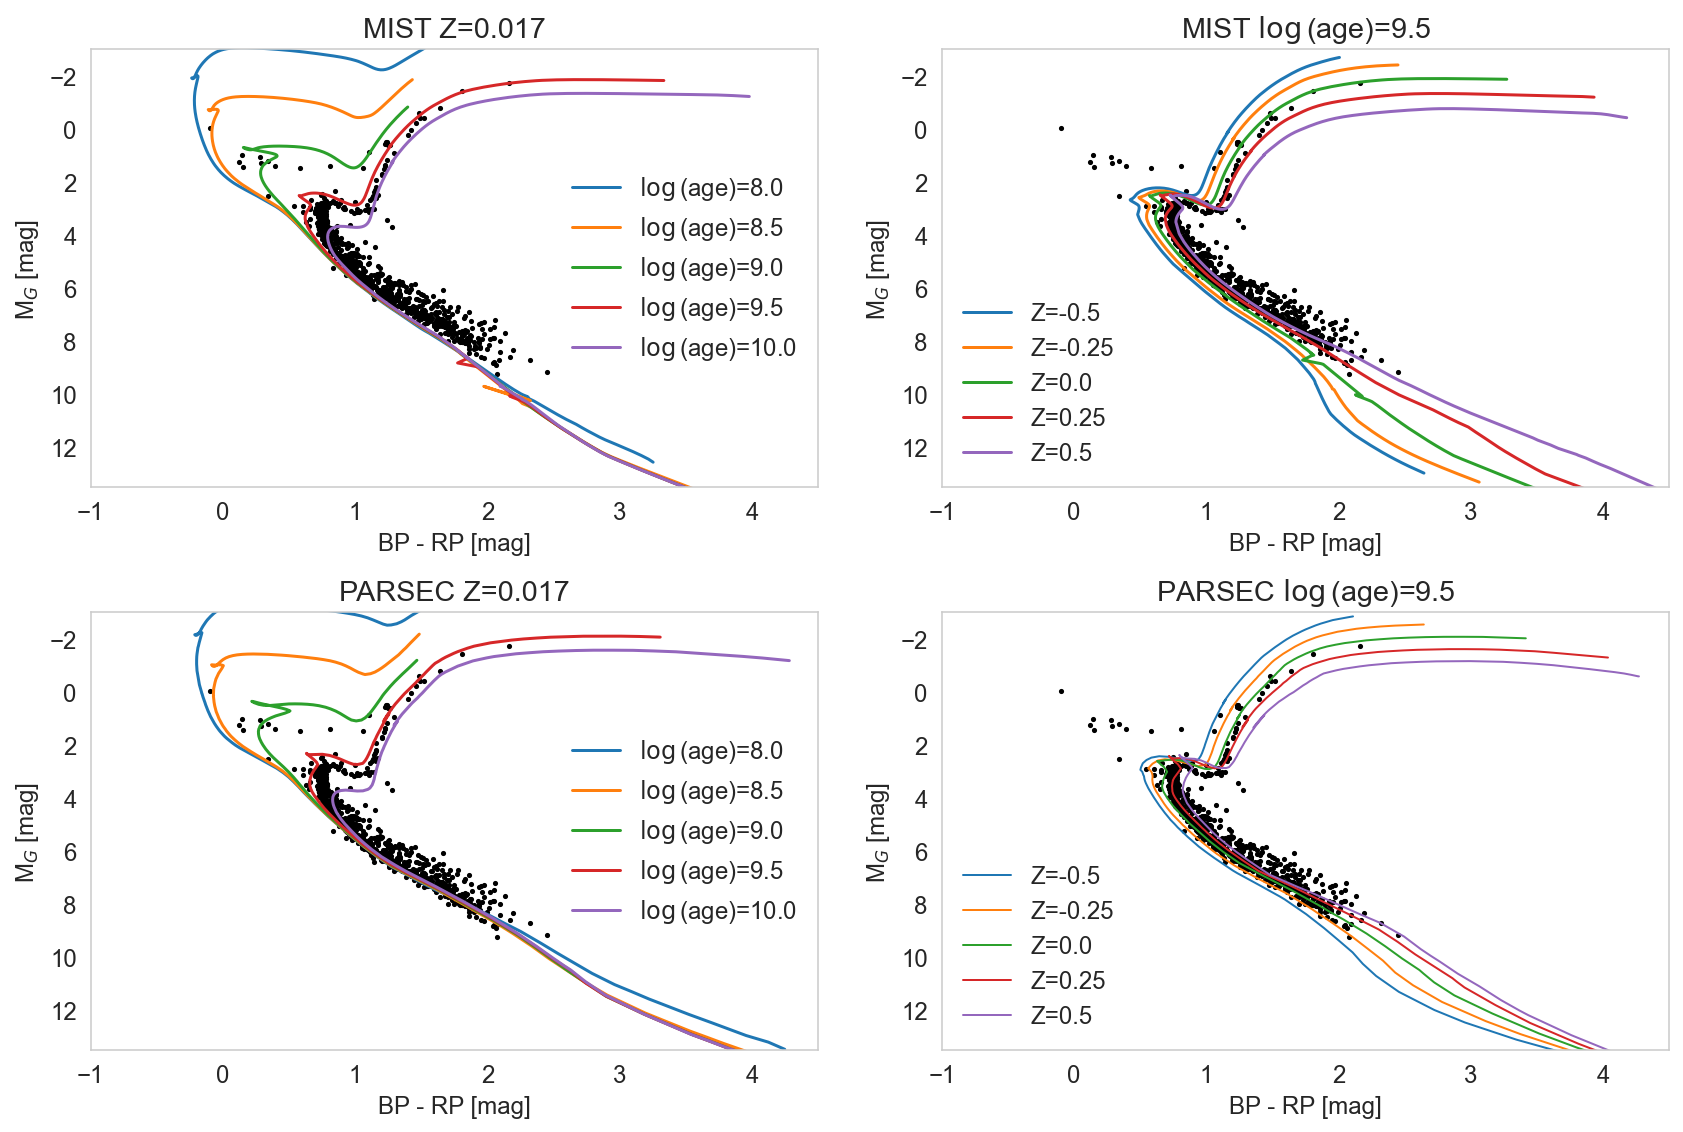

In [22]:
### MIST FIXED METALLICITY ###

m67_log_age = np.array([8.0, 8.5, 9.0, 9.5, 10.0])

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
process_and_plot_cmd(m67_tbl_f["bp_rp"], m67_tbl_f["mg"], "MIST Z=0.017")

for i, age in enumerate(m67_log_age):
    # filter for MS, RGB, and age
    tmist_m67_fixed_z_filtered = tmist_m67_fixed_z[
        (tmist_m67_fixed_z["log10_isochrone_age_yr"]==age)&
        (tmist_m67_fixed_z["phase"]>=-1.0)&
        (tmist_m67_fixed_z["phase"]<3.0)
    ]
    mist_m67_fixed_z_BP_RP = tmist_m67_fixed_z_filtered["Gaia_BP_EDR3"] - tmist_m67_fixed_z_filtered["Gaia_RP_EDR3"]
    mist_m67_fixed_z_G = tmist_m67_fixed_z_filtered["Gaia_G_EDR3"]
    plt.plot(mist_m67_fixed_z_BP_RP, mist_m67_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))

plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### MIST FIXED AGE ###

plt.subplot(2,2,2)
process_and_plot_cmd(m67_tbl_f["bp_rp"], m67_tbl_f["mg"], r"MIST $\log$(age)=9.5")

for i, processed_data in enumerate(tmist_m67_fixed_age_list_sorted):
    mist_m67_zini = processed_data["[Fe/H]_init"][0]
    mist_m67_fixed_age_BP_RP = processed_data["Gaia_BP_EDR3"] - processed_data["Gaia_RP_EDR3"]
    mist_m67_fixed_age_G = processed_data["Gaia_G_EDR3"]
    plt.plot(mist_m67_fixed_age_BP_RP, mist_m67_fixed_age_G, 
             label=f"Z={mist_m67_zini}", c=plt.cm.tab10(i))

plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED METALLICITY ###

plt.subplot(2,2,3)
process_and_plot_cmd(m67_tbl_f["bp_rp"], m67_tbl_f["mg"], "PARSEC Z=0.017")

for i, age in enumerate(m67_log_age):
    tparsec_m67_fixed_z_filtered = tparsec_m67_fixed_z[
        (tparsec_m67_fixed_z["logAge"]==age)&
        (tparsec_m67_fixed_z["label"]>=0)&
        (tparsec_m67_fixed_z["label"]<4)
    ]
    
    parsec_m67_fixed_z_BP_RP = tparsec_m67_fixed_z_filtered["G_BPmag"] - tparsec_m67_fixed_z_filtered["G_RPmag"]
    parsec_m67_fixed_z_G = tparsec_m67_fixed_z_filtered["Gmag"]
    plt.plot(parsec_m67_fixed_z_BP_RP, parsec_m67_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))
    
plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED AGE ###

m67_zinit = np.array([-0.5, -0.25, 0.0, 0.25, 0.5])

plt.subplot(2,2,4)
process_and_plot_cmd(m67_tbl_f["bp_rp"], m67_tbl_f["mg"], r"PARSEC $\log$(age)=9.5")

for i, z in enumerate(m67_zinit):
    tparsec_m67_fixed_age_filtered = tparsec_m67_fixed_age[
        (tparsec_m67_fixed_age["MH"]==z)&
        (tparsec_m67_fixed_age["label"]>=0)&
        (tparsec_m67_fixed_age["label"]<4)
    ]
    parsec_m67_fixed_age_BP_RP = tparsec_m67_fixed_age_filtered["G_BPmag"] - tparsec_m67_fixed_age_filtered["G_RPmag"]
    parsec_m67_fixed_age_G = tparsec_m67_fixed_age_filtered["Gmag"]
    plt.plot(parsec_m67_fixed_age_BP_RP, parsec_m67_fixed_age_G, 
             label=f"Z={z}", c=plt.cm.tab10(i), linewidth=1.0)
    
plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

With the applied filters, it can be observed that M67 has a sharp turn-off point in comparison to Hyades. These are stars that are transitioning out of their MS. Unlike Hyades, there are no sources in the WD region for M67. There are also a lack of faint sources in the lower region of the MS in comparison to Hyades, although this can be attributed to a strict query.

Both isochrones model indicate that M67 is older than $10^{9.5} \approx 3$ Gyr but younger than 10 Gyr (yeah should have narrowed the ange range...). Babusiax places the cluster at $10^{9.54} \approx 3.5$ Gyr.

MIST approximates the range of metallicity to be between 0.0 and 0.25 for the RGB of M67, but it does not model the MS well. PARSEC offers a more accurate fit to the gaia data, but with an estimated metallicity of 0.25, an order of magnitude above the 0.017 value present in Babusiaux.

# 0.3 NGC 6397

Values used in the query for NGC 6397 were found in Table 1 from Baumgardt et al 2018: $\alpha = 265.175385^{\circ}$, $\delta = -53.674335^{\circ}$, $\varpi = 0.416 \pm 0.010$ mas, $\mu_{\alpha} = 3.30 \pm 0.01$ mas/yr, $\mu_{\delta} = -17.60 \pm 0.01$ mas/yr. Here the parallax filter was relaxed to obtain more reasonable number of sources that agree with estimate for number of cluster members, since the cluster is much farther away. 

In [23]:
ngc6397_q_f = """SELECT DISTANCE(265.175385, -53.674335, ra, dec) AS ang_sep,
            phot_g_mean_mag+5*log10(parallax)-10 AS mg,
            bp_rp,ra,dec,source_id,parallax,pm,pmra,pmdec
        FROM gaiadr3.gaia_source
        WHERE DISTANCE(265.175385, -53.674335, ra, dec) < 32./60.
            AND parallax_over_error > 2
            AND parallax < 0.416 + 1.0
            AND parallax > 0.416 - 1.0
            AND pmra < 3.30 + 1.0
            AND pmra > 3.30 - 1.0
            AND pmdec < -17.60 + 1.0
            AND pmdec > -17.60 - 1.0
            AND phot_g_mean_flux_over_error>50
            AND phot_rp_mean_flux_over_error>20
            AND phot_bp_mean_flux_over_error>20
            AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
            AND visibility_periods_used>8
            AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))
"""

In [24]:
ngc6397_tbl_f = get_gaia_query(ngc6397_q_f)
print(len(ngc6397_tbl_f))

10407


Babusiaux identified 10055 members for NGC 6397, so the number of sources obtained with this query seem reasonable

In [25]:
### MIST FIXED METALLICITY ###

tmist_ngc6397_fixed_z = Table.read("ngc6397_MIST/MIST_iso_65bb3a999c2da.iso.cmd", format="ascii", header_start=-1)

### MIST FIXED AGE ###

tmist_ngc6397_fixed_age_list = process_data_file(mist_path, 10.0)
tmist_ngc6397_fixed_age_list_sorted = sorted(tmist_ngc6397_fixed_age_list, key=lambda x: x["[Fe/H]_init"][0])
tmist_ngc6397_fixed_age_list_sorted = tmist_ngc6397_fixed_age_list_sorted[-5:]

### PARSEC FIXED METALLICITY ###

parsec_path = "ngc6397_PARSEC/"

tparsec_ngc6397_fixed_z = Table.read(parsec_path + "output472189178065.dat", format='ascii', header_start=-2)

### PARSEC FIXED AGE ###

tparsec_ngc6397_fixed_age = Table.read(parsec_path + "output571382332899.dat", format='ascii', header_start=-2)

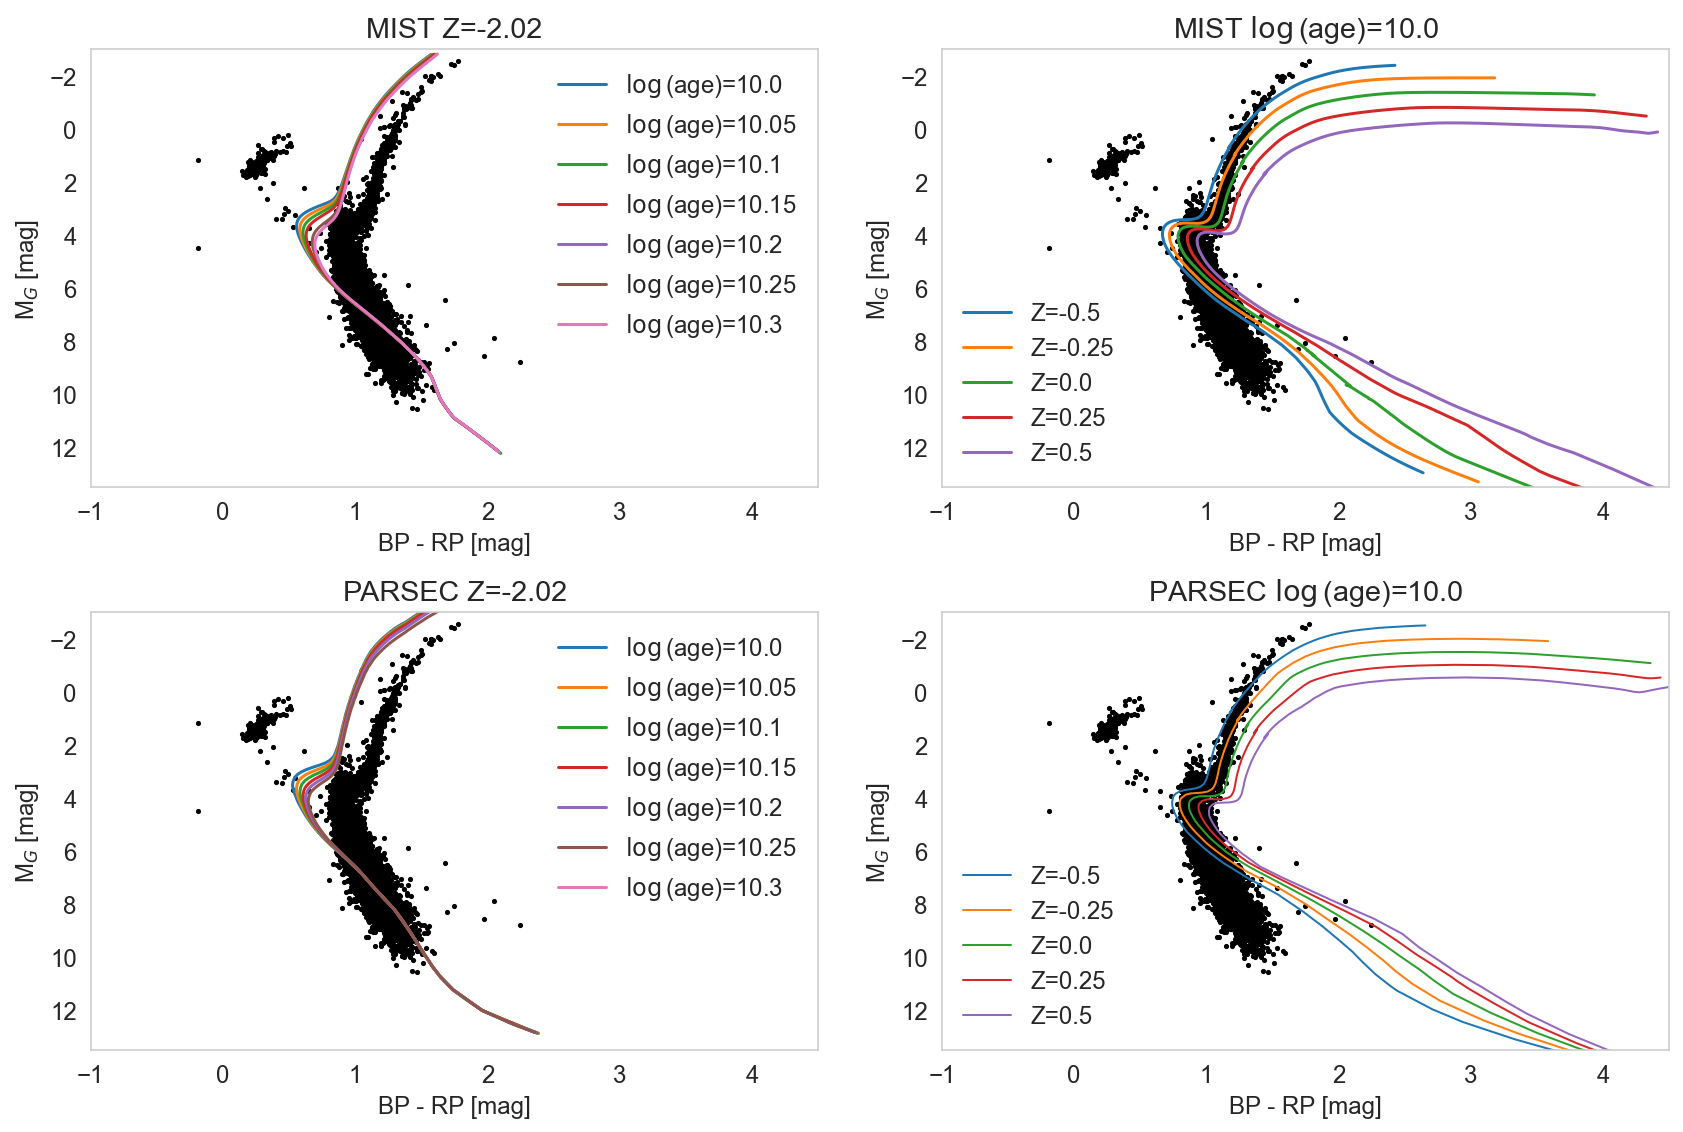

In [26]:
### MIST FIXED METALLICITY ###

ngc6397_log_age = np.array([10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3])

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
process_and_plot_cmd(ngc6397_tbl_f["bp_rp"], ngc6397_tbl_f["mg"], "MIST Z=-2.02")

for i, age in enumerate(ngc6397_log_age):
    # filter for MS, RGB, and age
    tmist_ngc6397_fixed_z_filtered = tmist_ngc6397_fixed_z[
        (tmist_ngc6397_fixed_z["log10_isochrone_age_yr"]==age)&
        (tmist_ngc6397_fixed_z["phase"]>=-1)&
        (tmist_ngc6397_fixed_z["phase"]<3)
    ]
    mist_ngc6397_fixed_z_BP_RP = tmist_ngc6397_fixed_z_filtered["Gaia_BP_EDR3"] - tmist_ngc6397_fixed_z_filtered["Gaia_RP_EDR3"]
    mist_ngc6397_fixed_z_G = tmist_ngc6397_fixed_z_filtered["Gaia_G_EDR3"]
    plt.plot(mist_ngc6397_fixed_z_BP_RP, mist_ngc6397_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))

plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### MIST FIXED AGE ###

plt.subplot(2,2,2)
process_and_plot_cmd(ngc6397_tbl_f["bp_rp"], ngc6397_tbl_f["mg"], r"MIST $\log$(age)=10.0")

for i, processed_data in enumerate(tmist_ngc6397_fixed_age_list_sorted):
    mist_ngc6397_zini = processed_data["[Fe/H]_init"][0]
    mist_ngc6397_fixed_age_BP_RP = processed_data["Gaia_BP_EDR3"] - processed_data["Gaia_RP_EDR3"]
    mist_ngc6397_fixed_age_G = processed_data["Gaia_G_EDR3"]
    plt.plot(mist_ngc6397_fixed_age_BP_RP, mist_ngc6397_fixed_age_G, 
             label=f"Z={mist_ngc6397_zini}", c=plt.cm.tab10(i))

plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED METALLICITY ###

plt.subplot(2,2,3)
process_and_plot_cmd(ngc6397_tbl_f["bp_rp"], ngc6397_tbl_f["mg"], "PARSEC Z=-2.02")

for i, age in enumerate(ngc6397_log_age):
    tparsec_ngc6397_fixed_z_filtered = tparsec_ngc6397_fixed_z[
        (tparsec_ngc6397_fixed_z["logAge"]==age)&
        (tparsec_ngc6397_fixed_z["label"]>=0)&
        (tparsec_ngc6397_fixed_z["label"]<4)
    ]
    
    parsec_ngc6397_fixed_z_BP_RP = tparsec_ngc6397_fixed_z_filtered["G_BPmag"] - tparsec_ngc6397_fixed_z_filtered["G_RPmag"]
    parsec_ngc6397_fixed_z_G = tparsec_ngc6397_fixed_z_filtered["Gmag"]
    plt.plot(parsec_ngc6397_fixed_z_BP_RP, parsec_ngc6397_fixed_z_G, label=f"$\log$(age)={age}", c=plt.cm.tab10(i))
    
plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

### PARSEC FIXED AGE ###

ngc6397_zinit = np.array([-0.5, -0.25, 0.0, 0.25, 0.5])

plt.subplot(2,2,4)
process_and_plot_cmd(ngc6397_tbl_f["bp_rp"], ngc6397_tbl_f["mg"], r"PARSEC $\log$(age)=10.0")

for i, z in enumerate(ngc6397_zinit):
    tparsec_ngc6397_fixed_age_filtered = tparsec_ngc6397_fixed_age[
        (tparsec_ngc6397_fixed_age["MH"]==z)&
        (tparsec_ngc6397_fixed_age["label"]>=0)&
        (tparsec_ngc6397_fixed_age["label"]<4)
    ]
    parsec_ngc6397_fixed_age_BP_RP = tparsec_ngc6397_fixed_age_filtered["G_BPmag"] - tparsec_ngc6397_fixed_age_filtered["G_RPmag"]
    parsec_ngc6397_fixed_age_G = tparsec_ngc6397_fixed_age_filtered["Gmag"]
    plt.plot(parsec_ngc6397_fixed_age_BP_RP, parsec_ngc6397_fixed_age_G, 
             label=f"Z={z}", c=plt.cm.tab10(i), linewidth=1.0)
    
plt.xlim(-1.0, 4.5)
plt.ylim(13.5, -3.0)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()

In comparison to the previous 2 clusters, NGC6397 appears to have many stars in the RGB. Along with the age range of the isochrone, it is evident that this globular cluster is much older than the others. They evidently do not fit well with the cluster data for the MS. Babusiaux has the metallicity at -2.02 and age at 13.5 Gyr, which are the values chosen to center the range of age and metallicity. An obvious difference between the PARSEC and MIST models is that the turnoff point in the PARSEC model is sharper. Additionally, PARSEC isochrones with metallicity around -0.5 to -0.25 fit the RGB well, with MIST having a similar accurate fit.